In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, uniform_filter1d
from scipy.signal import find_peaks

from Retinal_Segmentation import ind_layers as il

In [2]:
# WHAT TO DO:
# 1) Fix squiggly lines
# 2) Try customized cross-correlation based alignment algorithm to realign the A-scans:
# # https://opg.optica.org/oe/fulltext.cfm?uri=oe-18-20-21293&id=205891###

# Issues:
# 1) OS is higher than OSJ (should be flipped), many lines are squiggly (IM DELETING OSJ THO)
# 2) For noisy images, they look fine at peak point images. Only after, do they start to lose lines.

# Solutions:
# 0) Try changing the Span to span = 15 to see whether it'll be less squiggly
# 0.5) Fix mask_non_relevant_areas

# Notes
# With NORMAL-1384-2, all the way up to Prelim/Final boundary image is good.
# The upper retinal boundaries can be distinguished better, maybe less filter of peak points?
# BUT, the final output is bad, so it is definitely how the layers are defined (ind_layers.py)

In [3]:
def resizing(image):
    """
    To center image, add contouring, thresholds, and padding here.
    """
    left_half = image[:, :image.shape[1] // 2]  # Crop left half

    # Resize while preserving aspect ratio
    h, w = left_half.shape[:2]
    scale = 224 / max(h, w)
    resized = cv2.resize(left_half, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LANCZOS4)

    # Pad to 224x224
    top_pad = (224 - resized.shape[0]) // 2
    bottom_pad = 224 - resized.shape[0] - top_pad
    left_pad = (224 - resized.shape[1]) // 2
    right_pad = 224 - resized.shape[1] - left_pad
    padded_image = cv2.copyMakeBorder(resized, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)

    return padded_image


def gaussian_smooth(image, kernel_size, sigma):
    """Apply Gaussian smoothing."""
    return cv2.GaussianBlur(image, kernel_size, sigma)


def apply_median_filter(image, size):
    """Apply median filter to remove noise."""
    return median_filter(image, size=size)


def apply_gradient(image, template):
    """Apply a gradient template to the image to highlight boundaries."""
    return cv2.filter2D(image, -1, template)


def image_enhancement(image):
    # Step 1: Denoising
    filtered_image = apply_median_filter(image, size=(3, 5))  # Median filtering
    denoised_image = gaussian_smooth(filtered_image, (3, 9), 1)  # Gaussian smoothing

    # Step 2: Compute contrast scale for dynamic gradient templates
    intensity_range = np.max(denoised_image) - np.min(denoised_image)
    contrast_scale = intensity_range / 100  # Scale factor for gradient templates

    # Step 3: Apply adaptive ascending gradient template for dark-to-bright boundaries
    ascending_template = np.array([-0.2, -0.2, -0.2, -0.2, -0.2, 0.5, 0.5]).reshape(-1, 1)
    adaptive_ascending_template = ascending_template * contrast_scale  # Scale template
    gradient_asc = apply_gradient(denoised_image, adaptive_ascending_template)
    gradient_asc = gaussian_smooth(gradient_asc, (3, 9), 1)  # Gaussian smoothing

    # Step 4: Apply adaptive descending gradient template for bright-to-dark boundaries
    descending_template = np.array([0.5, 0.5, -0.2, -0.2, -0.2, -0.2, -0.2]).reshape(-1, 1)
    adaptive_descending_template = descending_template * contrast_scale  # Scale template
    gradient_desc = apply_gradient(denoised_image, adaptive_descending_template)
    gradient_desc = gaussian_smooth(gradient_desc, (3, 9), 1)

    # Step 5: Manage boundary conditions (shift gradients down by 2 rows)
    m, n = denoised_image.shape

    gra_1 = np.zeros((m, n))  # for ascending gradient
    gra_1[2:m, :] = gradient_asc[0:m - 2, :]  # for descending gradient

    gra_2 = np.zeros((m, n))
    gra_2[2:m, :] = gradient_desc[0:m - 2, :]

    # Step 6: Large-scale smoothing (further smoothing of already denoised image)
    large_smooth_template = gaussian_smooth(denoised_image, (31, 11), 9)

    # Step 7: Boundary enhancement for both gradients separately (multiply point-to-point to weaken outside noise)
    boundary_img_asc = np.multiply(gra_1, large_smooth_template) / 256  # Dark-to-bright boundaries
    boundary_img_desc = np.multiply(gra_2, large_smooth_template) / 256  # Bright-to-dark boundaries

    return gradient_asc, gradient_desc, large_smooth_template, boundary_img_asc, boundary_img_desc, denoised_image


def non_maximum_suppression(image):
    """Perform non-maximum suppression to eliminate duplicate detections and select the most relevant detected
    objects (to detect peak points)."""

    m, n = image.shape
    gradient_magnitude = np.zeros_like(image)  # Initialize output array with zeros

    for j in range(n):  # Iterate over columns
        for i in range(1, m - 1):  # Iterate over rows, skipping the first and last
            if image[i, j] >= image[i - 1, j] and image[i, j] >= image[i + 1, j]:
                gradient_magnitude[i, j] = image[i, j]
            else:
                gradient_magnitude[i, j] = 0

    return gradient_magnitude


def pathExt2D_212(image, y1, x1):  # Multipoint boundary search
    """
    Perform path extension based on the input matrix I and the initial seed point (y1, x1).

    Args:
        image (numpy.ndarray): Input 2D array (image or matrix).
        y1 (int): Initial y-coordinate (row).
        x1 (int): Initial x-coordinate (column).

    Returns:
        numpy.ndarray: Binary 2D array where the extended path is marked as 1.
    """

    k = 1
    m, n = image.shape
    seed = image[y1, x1]
    boundary_paths = np.zeros_like(image, dtype=int)
    boundary_paths[y1, x1] = 1

    weights = 3 * np.ones((2 * k + 1, 1)) * 0.01 * np.max(image)
    weights[k] = 1

    cx1, cx2 = x1, x1
    cy1, cy2 = y1, y1

    while cx1 > 0:
        cx1 -= 1
        row_start = max(cy1 - k, 0)
        row_end = min(cy1 + k + 1, m)
        temp = image[row_start:row_end, cx1]

        # Handle invalid slices gracefully
        if temp.size == 0:
            print(f"Skipping left extension at column {cx1} due to invalid slice.")
            continue

        adjusted_weights = weights[:temp.shape[0]].flatten()
        abs_diff = np.abs(temp - seed) + adjusted_weights
        min_index = np.argmin(abs_diff)
        cy1 = row_start + min_index
        boundary_paths[cy1, cx1] = 1

    while cx2 < n - 1:
        cx2 += 1
        row_start = max(cy2 - k, 0)
        row_end = min(cy2 + k + 1, m)
        temp = image[row_start:row_end, cx2]

        # Handle invalid slices gracefully
        if temp.size == 0:
            print(f"Skipping right extension at column {cx2} due to invalid slice.")
            continue

        adjusted_weights = weights[:temp.shape[0]].flatten()
        abs_diff = np.abs(temp - seed) + adjusted_weights
        min_index = np.argmin(abs_diff)
        cy2 = row_start + min_index
        boundary_paths[cy2, cx2] = 1

    return boundary_paths


def compute_path_map(image, grad_image, threshold_ratio, dark=200):
    """
    Compute a path map from the gradient image by applying thresholding,
    path extension, and Gaussian smoothing.

    Args:
        image (numpy.ndarray): Input NoMax image.
        grad_image (numpy.ndarray): Gradient image for path extension.
        threshold_ratio (float): Ratio to compute the threshold from max intensity.
        dark (int): Width of the central region to exclude.
        kernel_size (tuple): Size of the Gaussian kernel for smoothing.

    Returns:
        numpy.ndarray: Smoothed path map.
    """
    m, n = image.shape

    # # Thresholding
    # threshold = threshold_ratio * np.max(image)
    #
    # # Thresholding for upper layers (higher threshold)
    # threshold_upper = 0.1 * np.max(image)  # Same as MATLAB
    # row_upper, col_upper = np.where(image > threshold_upper)
    #
    # # Thresholding for lower layers (lower threshold)
    # threshold_lower = 0.05 * np.max(image)  # Lower threshold for weaker gradients
    # row_lower, col_lower = np.where(image > threshold_lower)
    #
    # # Combine both sets of peaks
    # row = np.concatenate([row_upper, row_lower])
    # col = np.concatenate([col_upper, col_lower])
    # total_peak_points = len(row)
    #
    # # Exclude central region (suppress central peaks)
    # no_max_th = image.copy()
    # no_max_th[:, n // 2 - dark:n // 2 + dark] = 0
    #
    # # Find points above threshold
    # row, col = np.where(no_max_th > threshold)
    # total_peak_points = len(row)
    #
    # # Initialize path map
    # path_map = np.zeros((m, n))
    #
    # # Compute path extensions for each peak point
    # for i in range(total_peak_points):
    #     path_extension = pathExt2D_212(grad_image, row[i], col[i])
    #     path_map += path_extension
    #
    # # Normalize path map
    # norm_path_map = 100 * path_map / total_peak_points
    #
    # # Gaussian smoothing
    # smoothed_map = gaussian_smooth(norm_path_map, (3, 3), 1)
    #
    # # Plot thresholded peaks
    # plt.imshow(no_max_th, cmap='gray')
    # plt.title("Thresholded Peaks")
    # plt.show()
    #
    # plt.imshow(grad_image, cmap='gray')
    # plt.scatter(col_upper, row_upper, c='red', label='Upper Peaks', s=1)
    # plt.scatter(col_lower, row_lower, c='blue', label='Lower Peaks', s=1)
    # plt.legend()
    # plt.title("Peaks Overlayed on Gradient Image")
    # plt.show()
    #
    # plt.imshow(no_max_th, cmap='gray')
    # plt.scatter(col_upper, row_upper, c='yellow', label='Upper Peaks', s=1)
    # plt.scatter(col_lower, row_lower, c='blue', label='Lower Peaks', s=1)
    # plt.legend()
    # plt.title("Thresholded Peaks")
    # plt.show()
    #
    # # Plot path map before and after smoothing
    # plt.imshow(path_map, cmap='gray')
    # plt.title("Path Map (Before Smoothing)")
    # plt.show()
    #
    # plt.imshow(smoothed_map, cmap='gray')
    # plt.title("Path Map (After Smoothing)")
    # plt.show()

    # Step 1: Identify retina region dynamically
    row_sum = np.sum(grad_image, axis=1)
    retina_threshold = 0.1 * np.max(row_sum)
    retina_rows = np.where(row_sum > retina_threshold)[0]

    if retina_rows.size == 0:
        print("Warning: No retina detected. Using fallback region.")
        retina_start = 0
        retina_end = m // 2
    else:
        retina_start = np.min(retina_rows)
        retina_end = np.max(retina_rows)

    retina_midpoint = (retina_start + retina_end) // 2

    # Step 2: Adaptive thresholds for upper and lower retina
    upper_retina = grad_image[retina_start:retina_midpoint, :]
    lower_retina = grad_image[retina_midpoint:retina_end, :]

    threshold_upper = 0.1 * np.max(upper_retina)
    threshold_lower = 0.05 * np.max(lower_retina)

    # Step 3: Detect peaks
    row_upper, col_upper = np.where(grad_image[retina_start:retina_midpoint, :] > threshold_upper)
    row_lower, col_lower = np.where(grad_image[retina_midpoint:retina_end, :] > threshold_lower)

    # Adjust row indices for lower peaks
    row_upper += retina_start
    row_lower += retina_midpoint

    # Step 4: Compute path map (same logic as before)
    total_peak_points = len(row_upper) + len(row_lower)
    path_map = np.zeros((m, n))

    for i in range(len(row_upper)):
        path_extension = pathExt2D_212(grad_image, row_upper[i], col_upper[i])
        path_map += path_extension

    for i in range(len(row_lower)):
        path_extension = pathExt2D_212(grad_image, row_lower[i], col_lower[i])
        path_map += path_extension

    # Normalize path map
    norm_path_map = 100 * path_map / total_peak_points

    # Gaussian smoothing
    smoothed_map = gaussian_smooth(norm_path_map, (3, 3), 1)

    return smoothed_map


def define_initial_boundaries(peak_points_asc, peak_points_desc, boundary_image_asc):
    ilm = il.detect_ilm(peak_points_asc, 10)  # Detect ILM
    iS, os, isy = il.detect_is(peak_points_asc, boundary_image_asc, ilm)  # Detect IS and OS
    osj = il.detect_osj(peak_points_asc, isy)  # Detect OSJ
    onl = il.detect_onl(peak_points_asc, iS)  # Detect ONL
    peak_points_asc_masked = il.mask_non_relevant_areas(peak_points_asc, ilm, iS)
    rpe = il.detect_rpe(peak_points_desc, osj, ilm, iS)

    peak_points_desc_masked = il.mask_non_relevant_areas(peak_points_desc, ilm, iS)

    return ilm, iS, os, osj, onl, peak_points_asc_masked, rpe, peak_points_desc_masked


def define_final_boundaries(final_mask_asc, final_map_desc, ilm, iS):
    inl, noMax_GCL = il.detect_inl(final_mask_asc, ilm, iS)

    nfl = il.detect_nfl(final_map_desc, ilm, iS, inl)
    opl, noMax_IPL = il.detect_opl(final_map_desc, ilm, iS, inl, nfl)
    ipl = il.detect_ipl(noMax_IPL, ilm, iS)
    gcl = il.detect_gcl(noMax_GCL, ilm, iS, ipl, nfl)

    return inl, nfl, opl, ipl, gcl


def smooth(data, span):
    return uniform_filter1d(data, size=span)


In [4]:
def main():
    # Step 0: Load image and resize it
    img = cv2.imread('Retinal_Segmentation/41598_2022_5550_MOESM3_ESM (1).tif')
    left_half = img[:, :img.shape[1] // 2]  # Cropped left half for superimposing (last step)

    # Convert image from BGR to Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change "img" to "left_half" for cropped pics

    # Step 1: Enhance the image
    (gradient_asc, gradient_desc, large_smoothed_image, boundary_img_asc,
     boundary_img_desc, denoised_image) = image_enhancement(gray_img)

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(gradient_asc, cmap='gray')
    plt.title("Ascending Gradient")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(gradient_desc, cmap='gray')
    plt.title("Descending Gradient")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(large_smoothed_image, cmap='gray')
    plt.title("Large-Scale Smoothed Image")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(boundary_img_asc, cmap='gray', vmin=0, vmax=20)
    plt.title("Boundary Image (Asc.)")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(boundary_img_desc, cmap='gray', vmin=0, vmax=20)
    plt.title("Boundary Image (Desc.)")
    plt.axis('off')

    plt.show()

    # Step 2: Perform Non-Maximum Suppression to get initial peak points for both boundary images
    peak_points_asc = non_maximum_suppression(boundary_img_asc)
    peak_points_desc = non_maximum_suppression(boundary_img_desc)

    # Step 2.5 (Optional): Visualizing the peak points
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(peak_points_asc, cmap='gray', vmin=0, vmax=10)
    plt.title("Peak Point Image (Asc)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(peak_points_desc, cmap='gray', vmin=0, vmax=20)
    plt.title("Peak Point Image (Desc)")
    plt.axis('off')

    plt.show()

    # # Step 2.75 (only if Cropping is needed): Crops each image in half
    # peak_points_asc = peak_points_asc[:, :peak_points_asc.shape[1] // 2]
    # peak_points_desc = peak_points_desc[:, :peak_points_desc.shape[1] // 2]
    # boundary_img_asc = boundary_img_asc[:, :boundary_img_asc.shape[1] // 2]
    # boundary_img_desc = boundary_img_desc[:, :boundary_img_desc.shape[1] // 2]

    # Step 3: Visualizing ilm, iS, osj, onl, rpe
    ilm, iS, os, osj, onl, peak_points_asc_masked, rpe, peak_points_desc_masked = define_initial_boundaries(
        peak_points_asc, peak_points_desc, boundary_img_asc)

    peak_points_asc = peak_points_asc_masked
    peak_points_desc = peak_points_desc_masked

    # Step 3.5: Visualize masked image to verify that relevant regions are preserved
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(peak_points_asc_masked, cmap='gray', vmin=2, vmax=4)
    plt.title("Masked Peak Points (Asc)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(peak_points_desc_masked, cmap='gray', vmin=1, vmax=3)
    plt.title("Masked Peak Points (Desc)")
    plt.axis('off')

    plt.show()

    # Step 3.75: Initial Check -- Visualizing ILM and IS on Ascending Gradient Image
    plt.figure(figsize=(10, 5))
    plt.imshow(peak_points_asc, cmap='gray')
    plt.plot(ilm, color='red', label='ILM')
    plt.plot(iS, color='blue', label='IS')
    plt.legend()
    plt.title("Ascending Gradient with ILM and IS Overlays")
    plt.show()

    # Step 4: Boundary Search and Selection
    initial_mask_asc = compute_path_map(peak_points_asc, boundary_img_asc, 0.1)
    initial_mask_desc = compute_path_map(peak_points_desc, boundary_img_desc, 0.15)

    # Step 5: Visualization of initial results for boundary search
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(initial_mask_asc, cmap='gray', vmin=2, vmax=4)
    plt.title("Prelim Boundary Image (Asc)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(initial_mask_desc, cmap='gray', vmin=1, vmax=3)
    plt.title("Prelim Boundary Image (Desc)")
    plt.axis('off')

    plt.show()

    # Step 6: Morphological Erosion for Desc Image (removes floating pixels, so only substantive objects remain)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  # Disk shape (3x3 kernel)
    initial_mask_desc = cv2.erode(initial_mask_desc, kernel, iterations=1)

    # Step 7: Refine and visualize the retinal boundary images
    final_mask_asc = non_maximum_suppression(initial_mask_asc)
    final_map_desc = non_maximum_suppression(initial_mask_desc)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(final_mask_asc, cmap='gray', vmin=0.6, vmax=2)
    plt.title("Retinal Boundary Image (Asc)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(final_map_desc, cmap='gray', vmin=0.5, vmax=2)
    plt.title("Retinal Boundary Image (Desc)")
    plt.axis('off')

    plt.show()

    # Step 8: Visualizing/detecting remaining boundaries
    inl, nfl, opl, ipl, gcl = define_final_boundaries(final_mask_asc, final_map_desc, ilm, iS)

    # Step 9: Smoothen individual layers
    span = 10  # Smoothing window
    ilm = smooth(ilm, span)
    iS = smooth(iS, span)
    osj = smooth(osj, span)
    onl = smooth(onl, span)
    inl = smooth(inl, span)
    gcl = smooth(gcl, span)
    os = smooth(os, span)
    nfl = smooth(nfl, span)
    opl = smooth(opl, span * 2)
    ipl = smooth(ipl, span)
    rpe = smooth(rpe, span)

    # Step 10: Superimpose individual detected boundaries on original image
    ax = 10
    width = 1.5  # Line width

    # Handle possible 3D or higher-dimensional images
    if len(img.shape) == 2:
        m, n = img.shape
    elif len(img.shape) == 3:
        m, n, _ = img.shape

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img[:, ax:n - ax], cmap='gray', aspect='auto')  # Display image in grayscale
    # plt.imshow(left_half[:, ax:n - ax], cmap='gray', aspect='auto')  # Cropped images

    # Plot the boundaries
    plt.plot(ilm[ax:n - ax], color='red', linewidth=width, label='ILM')
    plt.plot(nfl[ax:n - ax], color='skyblue', linewidth=width, label='NFL')
    # plt.plot(gcl[ax:n - ax], color='orange', linewidth=width, label='GCL')
    plt.plot(ipl[ax:n - ax], color='cyan', linewidth=width, label='IPL')
    plt.plot(inl[ax:n - ax], color='yellow', linewidth=width, label='INL')
    plt.plot(opl[ax:n - ax] + 2, color='saddlebrown', linewidth=width, label='OPL')
    plt.plot(onl[ax:n - ax], color='turquoise', linewidth=width, label='ONL')
    plt.plot(iS[ax:n - ax], color='navy', linewidth=width, label='IS')
    plt.plot(osj[ax:n - ax], color='green', linewidth=width, label='OSJ')
    plt.plot(os[ax:n - ax], color='khaki', linewidth=width, label='OS')
    plt.plot(rpe[ax:n - ax], color='purple', linewidth=width, label='RPE')

    # Add legend and labels
    plt.legend(loc='lower left')
    plt.title("Smoothed Boundaries on Image")
    plt.xlabel("Column Index")
    plt.ylabel("Pixel Intensity")
    plt.show()



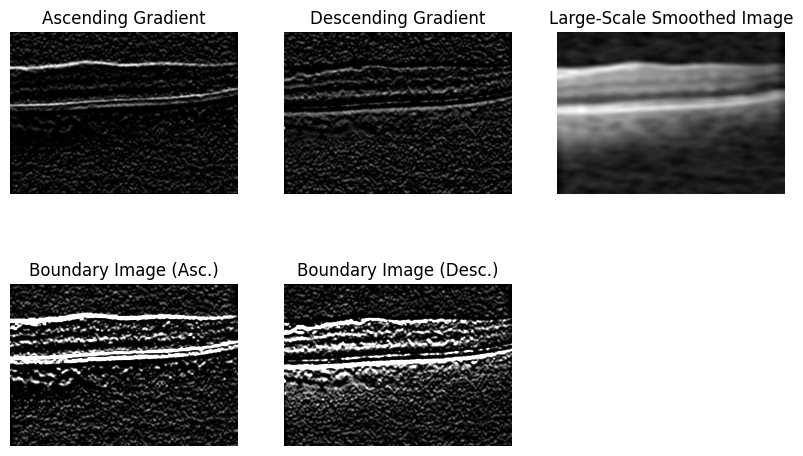

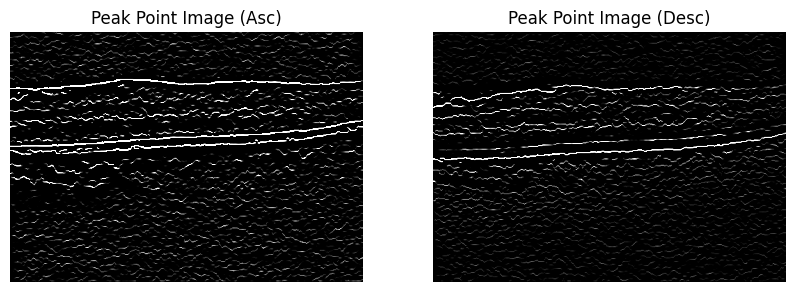

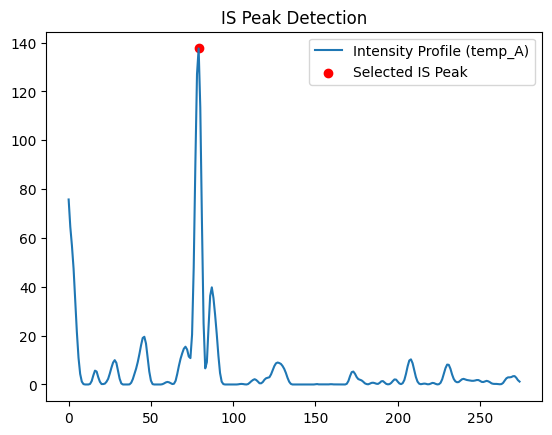

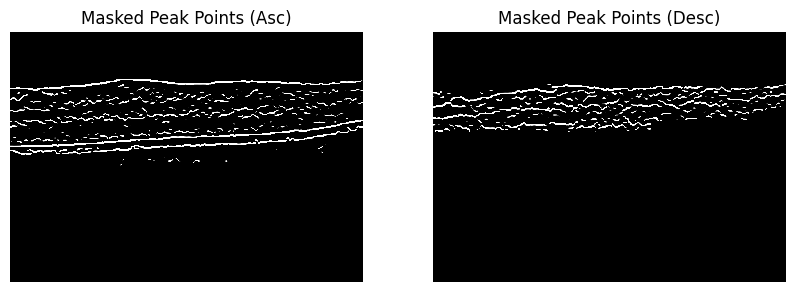

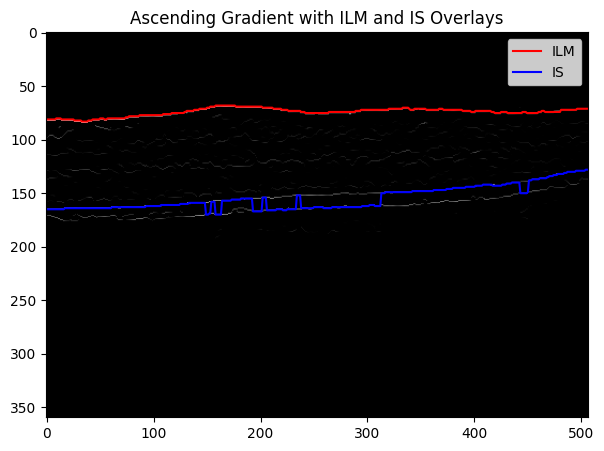

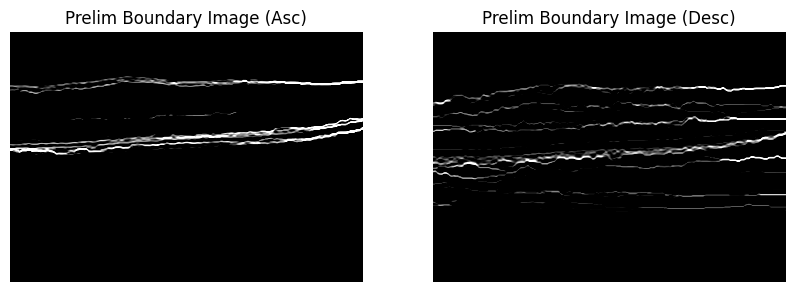

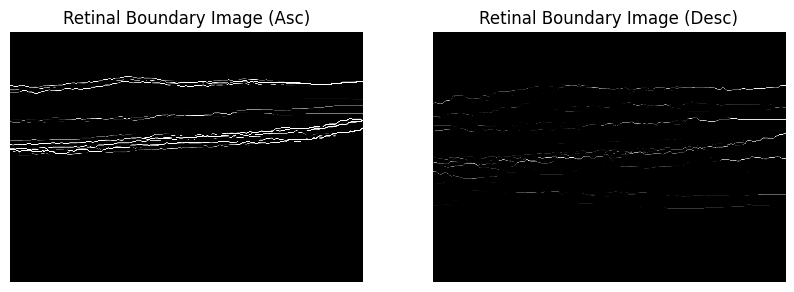

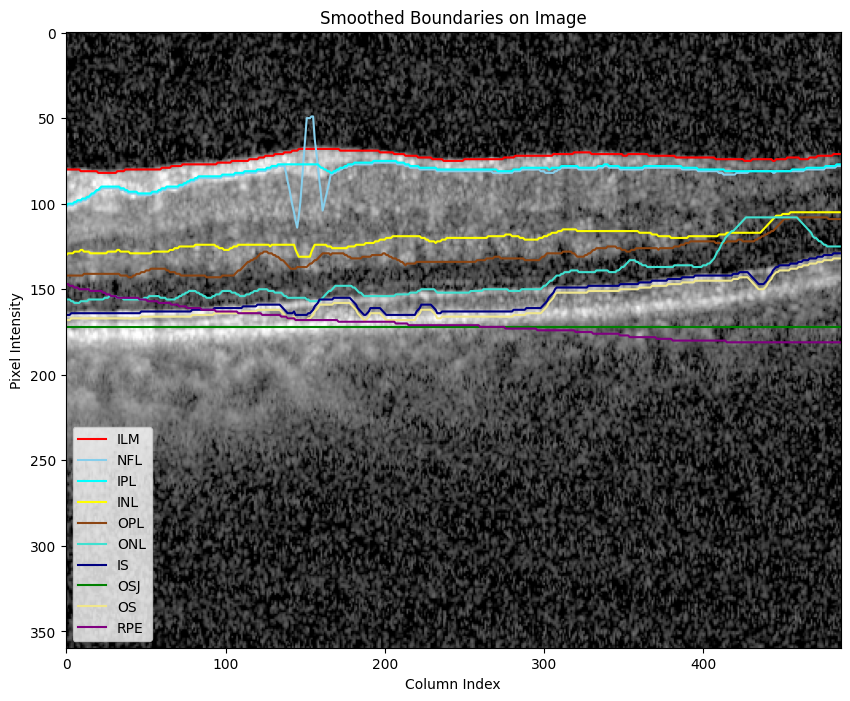

In [5]:
main()